<a href="https://colab.research.google.com/github/salazarcristian1014/Students-Performance/blob/main/Students_performance2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/StudentPerformanceFactors (1).csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Display basic information about the dataset

In [ ]:
df_info = df.info()

# Display the first few rows of the dataset to understand its structure
df_head = df.head()

# Check for missing values
missing_values = df.isnull().sum()

# Perform basic statistical analysis
basic_stats = df.describe()

(df_info, df_head, missing_values, basic_stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

(None,
    Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
 0             23          84                  Low                High   
 1             19          64                  Low              Medium   
 2             24          98               Medium              Medium   
 3             29          89                  Low              Medium   
 4             19          92               Medium              Medium   
 
   Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
 0                         No            7               73              Low   
 1                         No            8               59              Low   
 2                        Yes            7               91           Medium   
 3                        Yes            8               98           Medium   
 4                        Yes            6               65           Medium   
 
   Internet_Access  Tutoring_Sessions Family_Income Teacher_Quali

2. Data cleaning and imputation

In [ ]:
df['Teacher_Quality'].fillna(df['Teacher_Quality'].mode()[0], inplace=True)

df['Parental_Education_Level'].fillna('Unknown', inplace=True)

df['Distance_from_Home'].fillna(df['Distance_from_Home'].mode()[0], inplace=True)

missing_values_after_imputation = df.isnull().sum()

print("Missing values after imputation", missing_values_after_imputation)


Missing values after imputation Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


transform categorical columns to numerical:

In [ ]:
# Select the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Using LabelEncoder to transform categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save the label encoders in case we need to reverse later

# Check the first few rows of the transformed dataset
df.head(), categorical_columns

(   Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
 0             23          84                     1                    0   
 1             19          64                     1                    2   
 2             24          98                     2                    2   
 3             29          89                     1                    2   
 4             19          92                     2                    2   
 
    Extracurricular_Activities  Sleep_Hours  Previous_Scores  Motivation_Level  \
 0                           0            7               73                 1   
 1                           0            8               59                 1   
 2                           1            7               91                 2   
 3                           1            8               98                 2   
 4                           1            6               65                 2   
 
    Internet_Access  Tutoring_Sessions  Family_I

3. Advanced Exploratory Data Analysis

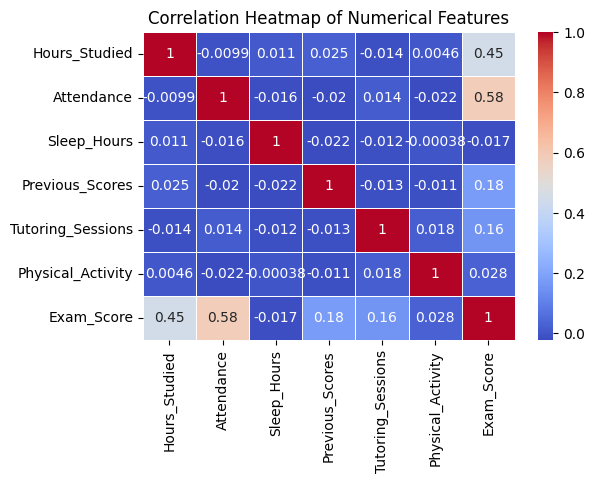

In [ ]:
# Filter only the numerical columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Create the correlation matrix
plt.figure(figsize=(6, 4))
corr_matrix = numeric_df.corr()

# Generate the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


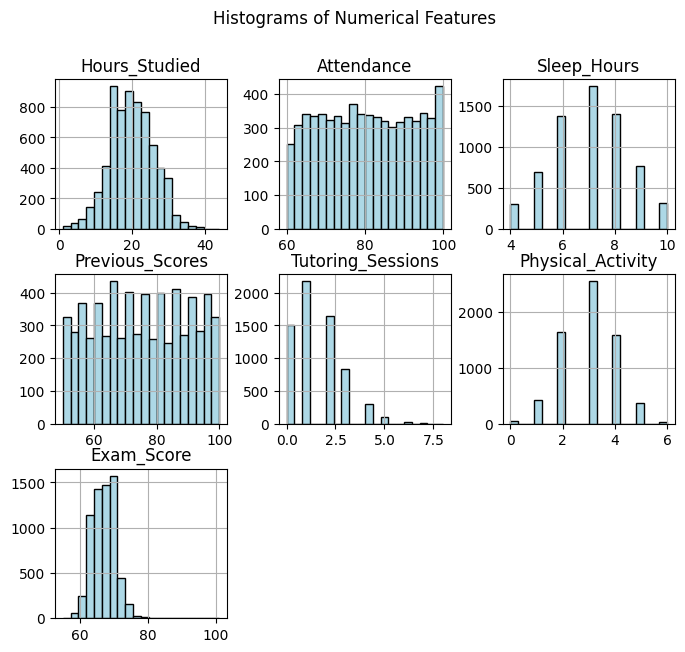

In [ ]:
# Histograms of numerical columns
df.hist(figsize=(8, 7), bins=20, color='lightblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

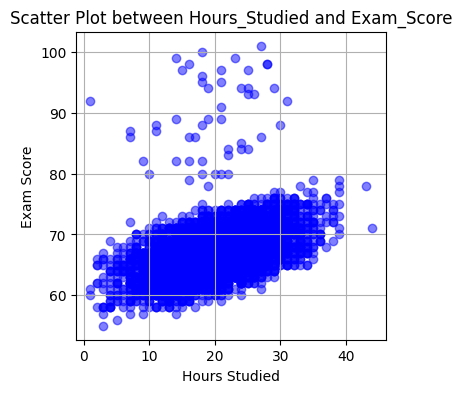

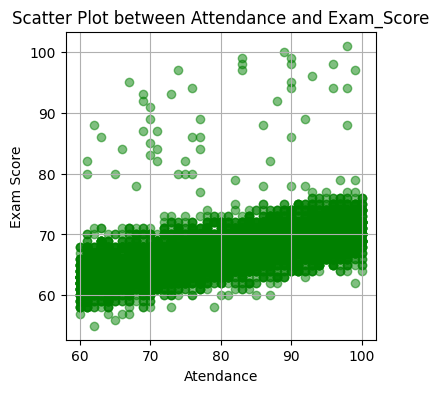

In [ ]:
# Scatter plot between 'Hours_Studied' and 'Exam_Score'
plt.figure(figsize=(4, 4))
plt.scatter(df['Hours_Studied'], df['Exam_Score'], alpha=0.5, c='blue')
plt.title('Scatter Plot between Hours_Studied and Exam_Score')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.grid(True)
plt.show()

# Scatter plot between 'Previous_Scores' and 'Exam_Score'
plt.figure(figsize=(4, 4))
plt.scatter(df['Attendance'], df['Exam_Score'], alpha=0.5, c='green')
plt.title('Scatter Plot between Attendance and Exam_Score')
plt.xlabel('Atendance')
plt.ylabel('Exam Score')
plt.grid(True)
plt.show()


"From the previous graphs and according to our heatmap, we can deduce that there is a positive correlation between study hours, attendance, and the total exam score. However, we have not yet observed the correlation that may exist between the Exam_Score column and the columns that previously had categorical variables and were encoded into numerical values. For this, we will use a mix of Pearson/Spearman correlation for numerical variables and Cramer’s V for the encoded categorical variables."

In [ ]:
# Function to calculate Cramer's V for categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Initialize an empty dictionary to store correlations
correlations = {}

# Get the list of all columns (both numerical and categorical encoded columns)
all_columns = df.columns.drop('Exam_Score')  # Assuming 'Exam_Score' is the target variable

# Loop over each column and calculate appropriate correlation
for col in all_columns:
    if df[col].dtype == 'object':  # Categorical column (non-numeric)
        # Calculate Cramer's V for categorical columns
        correlations[col] = cramers_v(df[col], df['Exam_Score'])
    else:
        # Use Spearman for numerical columns
        correlations[col], _ = spearmanr(df[col], df['Exam_Score'])

# Convert the correlations dictionary to a DataFrame for better readability
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation with Exam_Score'])

# Sort the correlations in descending order
correlation_df = correlation_df.sort_values(by='Correlation with Exam_Score', ascending=False)

# Display the result
print(correlation_df)

                      Variable  Correlation with Exam_Score
1                   Attendance                     0.672366
0                Hours_Studied                     0.480956
6              Previous_Scores                     0.191941
3          Access_to_Resources                     0.164549
9            Tutoring_Sessions                     0.163940
2         Parental_Involvement                     0.151153
15       Learning_Disabilities                     0.146276
16    Parental_Education_Level                     0.116515
17          Distance_from_Home                     0.114189
13              Peer_Influence                     0.113207
4   Extracurricular_Activities                     0.106505
8              Internet_Access                     0.105070
7             Motivation_Level                     0.103618
10               Family_Income                     0.103614
11             Teacher_Quality                     0.097607
18                      Gender          

"Definitely, the variables (Hours_Studied, Attendance) have the highest correlation with the Exam_Score variable, so we will proceed to select them with the following code."

In [ ]:
# Create the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model with the selected features
model.fit(X_selected, y)

# Get the feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select the most important features (e.g., the top 10)
top_features = feature_importance_df.head(10)['Feature'].tolist()
print("Most important features:\n", top_features)

# Create a new dataset with the most important features
X_top_features = df[top_features]


Most important features:
 ['Attendance', 'Hours_Studied']


Train the model with the selected features

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 7.000526151327796
R-squared: 0.5047406962594514


"Now we will see a comparison to determine which type of model can provide a more accurate prediction, considering that:

MSE (Mean Squared Error): The lower this value, the better the model's performance in terms of error.
R² (R-squared): Values close to 1 indicate that the model better explains the variability of the data."

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Let's assume you already have the selected features in X and the target variable in y
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# List of models to try
models = {
    "Linear Regression": LinearRegression(),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Dictionary to store the results
results = {}

# Try each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {"MSE": mse, "R-squared": r2}

# Display the results
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['MSE']}, R-squared = {metrics['R-squared']}")

Linear Regression: MSE = 5.809117224063619, R-squared = 0.5890281259514629
SVM: MSE = 5.849985425795875, R-squared = 0.5861368636809541
Random Forest: MSE = 7.000526151327796, R-squared = 0.5047406962594514
XGBoost: MSE = 6.948151302615725, R-squared = 0.5084459781646729


Model Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='r2')

# Train
grid_search.fit(X_train, y_train)

# Show the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}, R-squared: {r2_score(y_test, y_pred)}")


Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
MSE: 6.43716271818044, R-squared: 0.5445964121902496


"Predictions on the test set (already seen):"

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# View the predictions
print(y_pred)

# If you want to compare the predictions with the actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head())


[65.17764488 66.92685889 69.85024197 ... 66.39621169 66.12739495
 69.72348214]
      Actual  Predicted
743       65  65.177645
5551      65  66.926859
3442      71  69.850242
6571      64  66.563078
4204      66  63.436108


"Predictions on a new dataset:"

In [ ]:
# Let's assume you have a new dataset in a DataFrame called new_data
# Make sure to preprocess this new dataset the same way as X_selected

# Make predictions on the new dataset
new_predictions = best_model.predict(new_data)

# Show the predictions
print(new_predictions)